Install Dependencies


In [ ]:
pip install tensorflow opencv-python matplotlib


In [ ]:
pip list

Package                            Version
---------------------------------- --------------------
absl-py                            1.4.0
accelerate                         0.34.2
aiohappyeyeballs                   2.4.3
aiohttp                            3.10.10
aiosignal                          1.3.1
alabaster                          0.7.16
albucore                           0.0.16
albumentations                     1.4.15
altair                             4.2.2
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.19.0
astropy                            6.1.4
astropy-iers-data                  0.2024.10.14.0.32.55
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.2.0
audioread      

In [170]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import cv2
import imghdr
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

In [171]:
gpus = tf.config.experimental.list_physical_devices('CPU')
gpus


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [172]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus :
  tf.config.experimental.set_memory_growth(gpu,True)

Remove Dodgy images


In [173]:
data_dir = './data'
list_dir = os.listdir(data_dir)
image_ext = ["jpeg", "jpg", "bmp", "png"]
print(list_dir)

['.ipynb_checkpoints', 'sad', 'happy']


In [174]:
for image_class in list_dir :
    for image in os.listdir(os.path.join(data_dir,image_class)):
       image_path = os.path.join(data_dir,image_class,image)
       try:
          img = cv2.imread(image_path)
          tip = imghdr.what(image_path)
          if tip not in image_ext:
             print("Image not in ext list {}".format(image_path))
             os.remove(image_path)
       except Exception as e:
          print("issue with the image {}".format(image_path))

issue with the image ./data/sad/.ipynb_checkpoints


Found 195 files belonging to 2 classes.


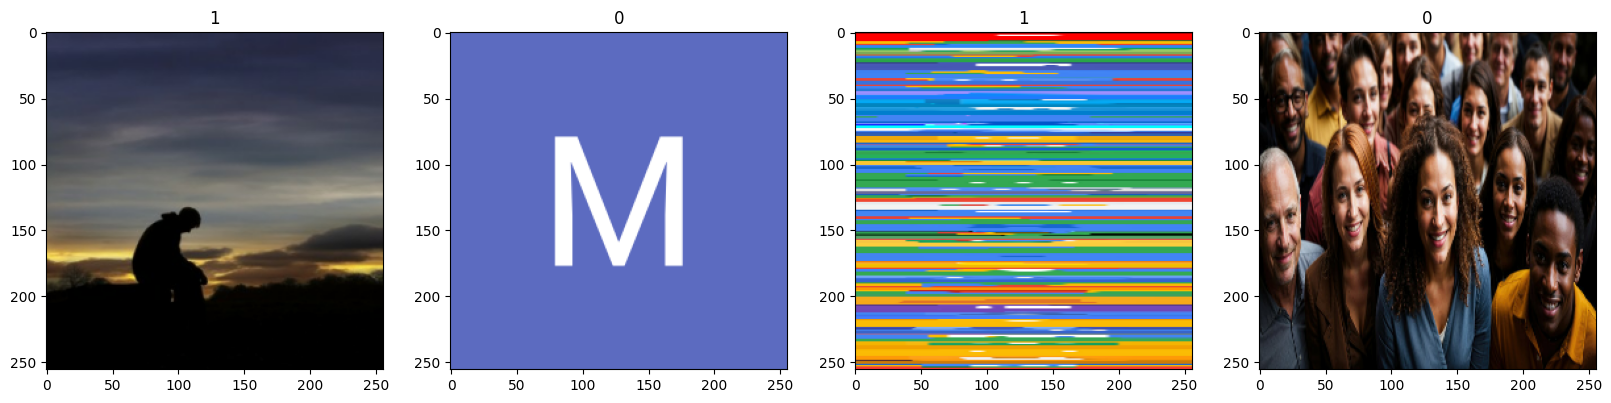

In [175]:
# class 1 = sad class 0 = happy

data = tf.keras.utils.image_dataset_from_directory(data_dir)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

flg,ax = plt.subplots(ncols=4,figsize = (20,20))
for idx,img in enumerate(batch[0][:4]):
   ax[idx].imshow(img.astype(int))
   ax[idx].title.set_text(batch[1][idx])

Preprocessing the Data

In [176]:
scaled = batch[0]/255
scaled.max()

1.0

scale data


In [177]:
data = data.map(lambda x,y:(x/255,y))

In [178]:
scaled_iterator = data.as_numpy_iterator()

In [179]:
batch = scaled_iterator.next()
batch[0].min()


0.0

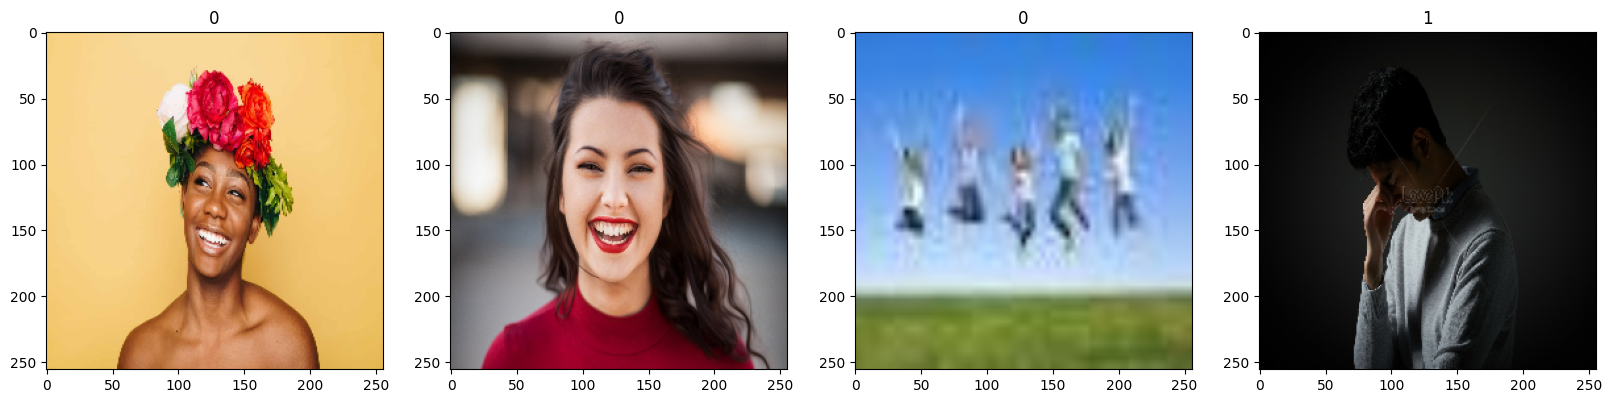

In [180]:
fig,ax = plt.subplots(ncols = 4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

Split data


In [181]:
len(data)

7

In [182]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2) + 1
test_size = int(len(data)*.1) + 1
total = train_size + val_size + test_size
print("all size : ",total)

all size :  7


In [183]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [184]:
len(train)

4

**Deep Learning Model **

In [185]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense,Flatten,Dropout

In [186]:
model = Sequential()


In [187]:
#

model.add(Conv2D(16,(3,3),1,activation='relu',input_shape =(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [188]:
model.compile('adam',loss =tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [189]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

Train

In [190]:
logdir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [191]:
hist = model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.4875 - loss: 1.8748 - val_accuracy: 0.3438 - val_loss: 1.0981
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4594 - loss: 0.9137 - val_accuracy: 0.5000 - val_loss: 0.6911
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.4781 - loss: 0.6883 - val_accuracy: 0.7344 - val_loss: 0.6882
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.7156 - loss: 0.6794 - val_accuracy: 0.5469 - val_loss: 0.6516
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.5385 - loss: 0.6573 - val_accuracy: 0.5469 - val_loss: 0.6255
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.6521 - loss: 0.5782 - val_accuracy: 0.7656 - val_loss: 0.5415
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.8292 - loss: 0.5095 - val_accuracy: 0.8125 - val_loss: 0.4458
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.8198 - loss: 0.4576 - val_accuracy: 0.6719 - val_loss: 0.5784
Epoch 9/

In [192]:
hist.history

{'accuracy': [0.4609375,
  0.4765625,
  0.453125,
  0.6875,
  0.5703125,
  0.6640625,
  0.828125,
  0.8203125,
  0.828125,
  0.9140625,
  0.859375,
  0.8984375,
  0.9140625,
  0.9453125,
  0.9375,
  0.9609375,
  0.984375,
  0.96875,
  0.9765625,
  0.96875],
 'loss': [1.952722191810608,
  0.8383408188819885,
  0.6911628842353821,
  0.6682403087615967,
  0.6344544291496277,
  0.5741739273071289,
  0.4927751123905182,
  0.46983182430267334,
  0.4033125638961792,
  0.3499104976654053,
  0.2863149642944336,
  0.22796157002449036,
  0.20751138031482697,
  0.17827066779136658,
  0.14276523888111115,
  0.1152290627360344,
  0.07036387175321579,
  0.08744697272777557,
  0.0801522359251976,
  0.07069563865661621],
 'val_accuracy': [0.34375,
  0.5,
  0.734375,
  0.546875,
  0.546875,
  0.765625,
  0.8125,
  0.671875,
  0.828125,
  0.921875,
  0.953125,
  0.875,
  0.890625,
  0.96875,
  0.9375,
  0.953125,
  0.984375,
  0.96875,
  0.984375,
  0.953125],
 'val_loss': [1.0981299877166748,
  0.691134

Plot performance

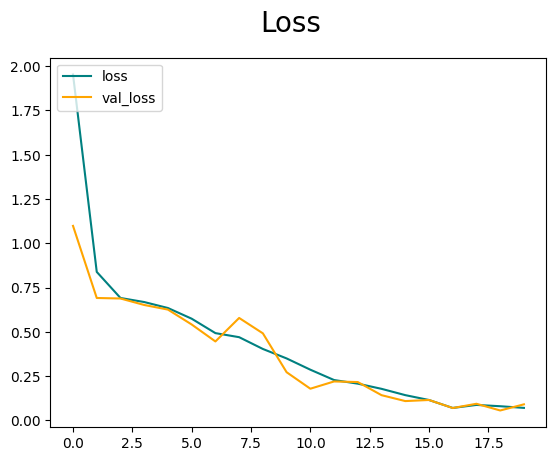

In [193]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize = 20)
plt.legend(loc="upper left")
plt.show()


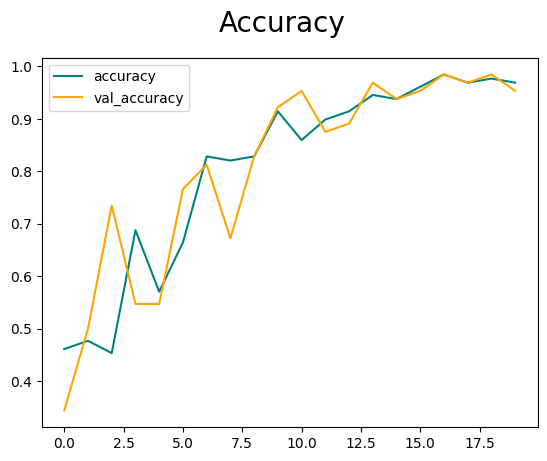

In [194]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize = 20)
plt.legend(loc="upper left")
plt.show()


Evaluate Performance

In [195]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy


In [196]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [197]:
len(test)

1

In [198]:
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


In [199]:
print(f'Presicions : {pre.result().numpy()}, Recall : {re.result().numpy()}, acc : {acc.result().numpy()}')

Presicions : 1.0, Recall : 1.0, acc : 1.0


Test

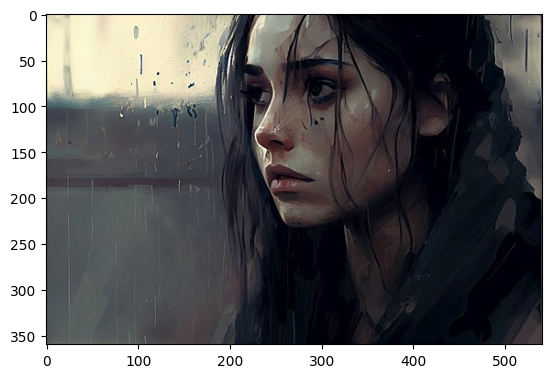

In [200]:
img = cv2.imread('Test/sadPerson.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

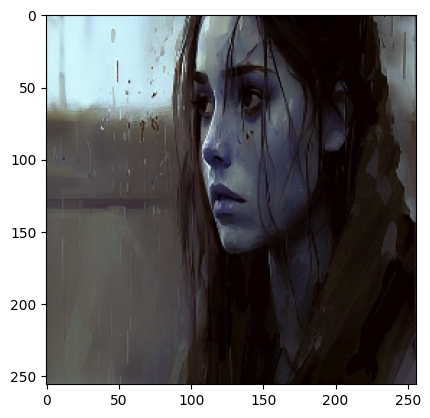

In [201]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [202]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


In [203]:
yhat

array([[0.9969943]], dtype=float32)

In [204]:
if yhat > 0.6 :
  print("this person is sad")
else:
  print("this person is happy")

this person is sad


Save the model


In [205]:
from tensorflow.keras.models import load_model


In [207]:
model.save(os.path.join("models","happymodel.h5"))


In [208]:
new_model = load_model(os.path.join("models","happymodel.h5"))

In [209]:
yhatnew = new_model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


In [210]:
if yhatnew > 0.6 :
  print("this person is sad")
else:
  print("this person is happy")

this person is sad
